In [ ]:
# !pip install contractions
# !pip install gensim
# !pip install textblob
import pickle
import contractions
from textblob import TextBlob
from gensim.models import Word2Vec
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import string
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
root_dir = "safecity-master/"

In [ ]:
def binary_dataframes(root_dir, category):
  '''
  Will return data specific to one of the category

  category = 'commenting' or 'groping' or 'ogling'
  '''

  dir = root_dir+'binary_classification/'
  train = pd.read_csv(dir+category+'_data/train.csv')
  cv = pd.read_csv(dir+category+'_data/dev.csv')
  test = pd.read_csv(dir+category+'_data/test.csv') 

  return pd.concat([train, cv], axis=0, ignore_index=True) , test

In [ ]:
train, _ = binary_dataframes(root_dir, 'commenting')
train

,Description,Category
0,"Was walking along crowded street, holding mums...",0
1,This incident took place in the evening.I was ...,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1
3,Incident happened inside the train,0
4,I witnessed an incident when a chain was bruta...,0
...,...,...
8186,I was returning to my home riding a bicycle wh...,1
8187,two boys on a bike commented and abused my fri...,1
8188,"During evening , a guy showed me a middle fing...",1
8189,It was a evening time two very young boys were...,0


In [ ]:
def fe(df):
  punctuation = string.punctuation
  df['char_count'] = df['Description'].apply(len)
  df['word_count'] = df['Description'].apply(lambda x: len(x.split()))
  df['word_density'] = df['char_count'] / (df['word_count']+1)
  df['punctuation_count'] = df['Description'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
  df['upper_case_word_count'] = df['Description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
  return df

def stop_word(sent):
  en_stops = set(stopwords.words('english'))

  filter = []
  for word in sent.split(" "): 
    if word.lower() not in en_stops or word.lower() == 'not':
        filter.append(word)
  
  return " ".join(filter)

# def remove_contractions(sent):
#   expanded_words = []    
#   for word in sent.split():
#     expanded_words.append(contractions.fix(word))   
#   return ' '.join(expanded_words)

# def special_char_removal(sent):
#   return re.sub('[^A-Za-z0-9]+', ' ', sent)

In [ ]:
def fetch_data(root_dir, rm_stopword, min_df, max_df, category=None):
  '''
  root_dir : <string> path of directory where data is stored

  rm_stopword: <bool> True or False

  min_freq: <int> word to consider having minimum frequency

  mix_freq: <int> word not to consider more than this frequency 

  category : <string> 'commenting' or 'ogling' or 'groping'
  '''

  
  train, test = binary_dataframes(root_dir, category)
  # train['Description'] = train['Description'].map(remove_contractions)
  # train['Description'] = train['Description'].map(special_char_removal)
  # test['Description'] = test['Description'].map(remove_contractions)
  # test['Description'] = test['Description'].map(special_char_removal)

  train = fe(train)
  test = fe(test)
    
  if rm_stopword:
    train['Description'] = train['Description'].map(stop_word)
    test['Description'] = test['Description'].map(stop_word)

  vec = TfidfVectorizer(min_df=min_df, max_df=max_df)
  vec.fit(train['Description'])
  with open('vectorizer_'+category+'.pkl', 'wb') as f:
    pickle.dump(vec, f)
    
  trans = vec.transform(train['Description'])
  train = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), train.drop(['Description'], axis=1)], axis=1)

  trans = vec.transform(test['Description'])
  test = pd.concat([pd.DataFrame(trans.toarray(), columns=vec.vocabulary_), test.drop(['Description'], axis=1)], axis=1)
  
  return train, test, vec

# Commenting

In [ ]:
train, test, _ =  fetch_data(root_dir=root_dir, rm_stopword=True, min_df=1, max_df=1404, category="commenting")

Y_train, X_train = train['Category'], train.drop(['Category'], axis=1)

Y_test, X_test = test['Category'], test.drop(['Category'], axis=1)

X_train

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,char_count,word_count,word_density,punctuation_count,upper_case_word_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183,36,4.945946,6,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89,16,5.235294,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85,18,4.473684,2,18
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,5,5.666667,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122,22,5.304348,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147,27,5.250000,1,2
8187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,22,5.260870,1,0
8188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109,24,4.360000,2,1
8189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231,44,5.133333,3,0


In [ ]:
clf = LGBMClassifier(random_state=42)
params = {
    'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.6min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001,
                                           0.0001]},
             return_train_score=True, verbose=1)

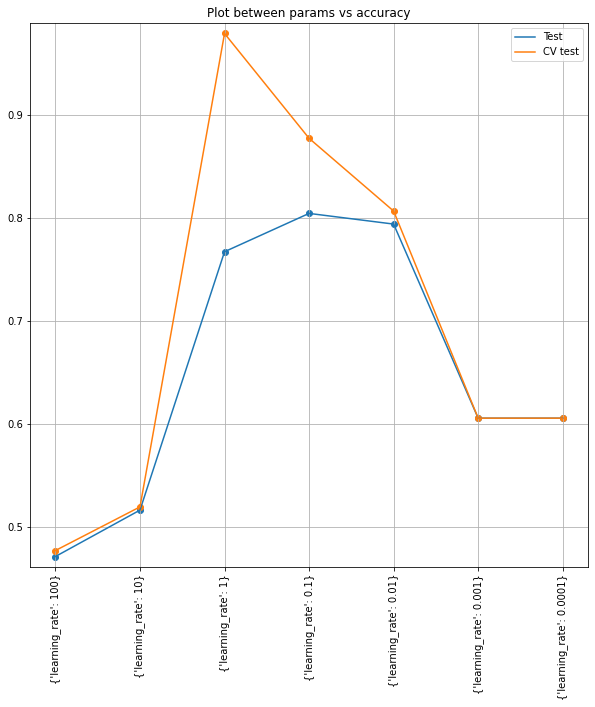

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, learning_rate=0.01, max_depth=1, n_estimators=9000, min_child_samples=19)
clf.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=1,
               min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=9000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print("Train accuracy : ", accuracy_score(Y_train, clf.predict(X_train)))
print("Test accuracy : ", accuracy_score(Y_test,   clf.predict(X_test)))

Train accuracy :  0.8165059211329508
Test accuracy :  0.8165784832451499


In [ ]:
clf.Booster.save_model('lgb_commenting.txt')

In [ ]:
import lightgbm as lgb
clf = lgb.Booster(model_file='lgb_commenting.txt')

In [ ]:
print("Train accuracy : ", accuracy_score(Y_train, [0 if i<=0.5 else 1 for i in clf.predict(X_train)]))
print("Test accuracy : ", accuracy_score(Y_test,   [0 if i<=0.5 else 1 for i in clf.predict(X_test)]))

Train accuracy :  0.8165059211329508
Test accuracy :  0.8165784832451499


In [ ]:
clf.predict(X_train)

array([0.14556178, 0.22224789, 0.15969186, ..., 0.25687317, 0.08572864,
       0.10363778])

# Ogling

In [ ]:
train, test, _ =  fetch_data(root_dir=root_dir, rm_stopword=True, min_df=1, max_df=1404, category="ogling")

Y_train, X_train = train['Category'], train.drop(['Category'], axis=1)

Y_test, X_test = test['Category'], test.drop(['Category'], axis=1)

X_train

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,char_count,word_count,word_density,punctuation_count,upper_case_word_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183,36,4.945946,6,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89,16,5.235294,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85,18,4.473684,2,18
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,5,5.666667,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122,22,5.304348,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147,27,5.250000,1,2
8187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,22,5.260870,1,0
8188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109,24,4.360000,2,1
8189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231,44,5.133333,3,0


In [ ]:
# clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, n_jobs=-1)

# params ={
#     "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
#     "penalty": ['l2', 'l1']
# }
clf = LGBMClassifier(random_state=42)
params = {
    'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=4, n_jobs=-1)
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  29 out of  35 | elapsed:  1.5min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.6min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001,
                                           0.0001]},
             return_train_score=True, verbose=4)

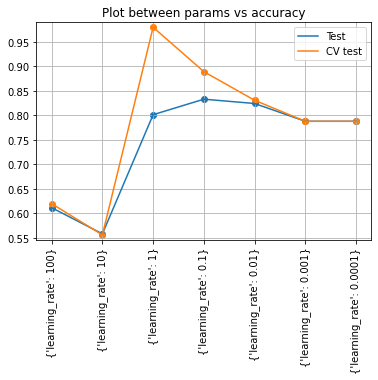

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, learning_rate=0.09, n_estimators=29, min_child_samples=5, reg_lambda=0.0009, reg_alpha=0.0009)
clf.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.09, max_depth=-1,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=29, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0009, reg_lambda=0.0009,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
print("Train accuracy : ", accuracy_score(Y_train, clf.predict(X_train)))
print("Test accuracy : ", accuracy_score(Y_test, clf.predict(X_test)))

Train accuracy :  0.849102673666219
Test accuracy :  0.8383303938859494


In [ ]:
clf.save_model('lgb_ogling.txt')

In [ ]:
import lightgbm as lgb
clf = lgb.Booster(model_file='lgb_ogling.txt')

In [ ]:
import lightgbm as lgb
clf = lgb.Booster(model_file='lgb_ogling.txt')
print("Train accuracy : ", accuracy_score(Y_train, [0 if i<=0.5 else 1 for i in clf.predict(X_train)]))
print("Test accuracy : ", accuracy_score(Y_test,   [0 if i<=0.5 else 1 for i in clf.predict(X_test)]))


Train accuracy :  0.849102673666219
Test accuracy :  0.8383303938859494


# Groping

In [ ]:
train, test, _ =  fetch_data(root_dir=root_dir, rm_stopword=True, min_df=1, max_df=1404, category="groping")

Y_train, X_train = train['Category'], train.drop(['Category'], axis=1)

Y_test, X_test = test['Category'], test.drop(['Category'], axis=1)

X_train

,walking,along,crowded,street,holding,mums,hand,elderly,man,groped,butt,turned,look,h7m,looked,away,while,12,yrs,old,then,incident,took,place,evening,metro,two,guys,started,staring,waiting,bus,came,bike,offering,liftvto,young,girls,happened,inside,...,crack,powerful,muscular,photocopying,boda,operators,ferry,thye,shapes,curvy,identifying,policing,oftenly,underage,relise,mention,gr,sensetive,impregnates,onlookers,lta,hrefhttp,download,cnet,freeyoutubedownloaderpro,30002071475329731,html,gtyoutube,downloaderlt,agt,folowing,cgroping,timr,conducter,gift,char_count,word_count,word_density,punctuation_count,upper_case_word_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183,36,4.945946,6,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89,16,5.235294,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85,18,4.473684,2,18
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,5,5.666667,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122,22,5.304348,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147,27,5.250000,1,2
8187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,22,5.260870,1,0
8188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109,24,4.360000,2,1
8189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231,44,5.133333,3,0


In [ ]:
# clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200, n_jobs=-1)

# params ={
#     "C": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
#     "penalty": ['l2', 'l1']
# }
clf = LGBMClassifier(random_state=42)
params = {
    'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

gs = GridSearchCV(clf, params, return_train_score=True, cv=5, verbose=4, n_jobs=-1)
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  29 out of  35 | elapsed:  1.4min remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [100, 10, 1, 0.1, 0.01, 0.001,
                                           0.0001]},
             return_train_score=True, verbose=4)

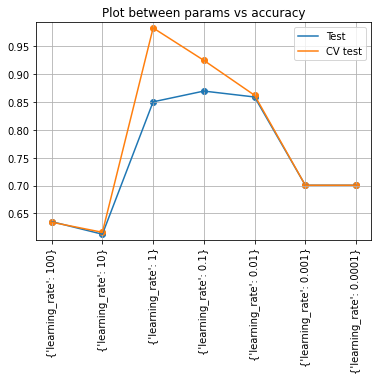

In [ ]:
plt.title("Plot between params vs accuracy")
plt.plot(gs.cv_results_['mean_test_score'], label='Test')
plt.plot(gs.cv_results_['mean_train_score'], label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),gs.cv_results_['mean_test_score'])
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),gs.cv_results_['mean_train_score'])

plt.ylim(min([min(gs.cv_results_['mean_test_score']), min(gs.cv_results_['mean_train_score'])])-0.01, max([max(gs.cv_results_['mean_test_score']), max(gs.cv_results_['mean_train_score'])])+0.01)

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.grid()
plt.legend()
plt.show()

In [ ]:
clf = LGBMClassifier(random_state=42, learning_rate=0.022, max_depth=1, n_estimators=9000, min_child_samples=19)
clf.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.022, max_depth=1,
               min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=9000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
print("Train accuracy : ", accuracy_score(Y_train, clf.predict(X_train)))
print("Test accuracy : ", accuracy_score(Y_test, clf.predict(X_test)))

Train accuracy :  0.8873153461115859
Test accuracy :  0.8712522045855379


In [ ]:
clf.booster_.save_model('lgb_groping.txt')

In [ ]:
import lightgbm as lgb
clf = lgb.Booster(model_file='lgb_groping.txt')
print("Train accuracy : ", accuracy_score(Y_train, [0 if i<=0.5 else 1 for i in clf.predict(X_train)]))
print("Test accuracy : ", accuracy_score(Y_test,   [0 if i<=0.5 else 1 for i in clf.predict(X_test)]))

Train accuracy :  0.8873153461115859
Test accuracy :  0.8712522045855379
